<a href="https://colab.research.google.com/github/sdlm/pytorch_mnist/blob/master/card_mask_unet_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import skimage.io as io
from tqdm import tqdm_notebook, tqdm

from skimage.draw import ellipse, polygon

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.losses import binary_crossentropy
import tensorflow as tf
import keras as keras

from keras import backend as K

from tqdm import tqdm_notebook

import multiprocessing as mp
cores_count = mp.cpu_count()

Using TensorFlow backend.


In [0]:
h_size = 256
w_size = 256
train_num = 10000
train_x = np.zeros((train_num, h_size, w_size, 3), dtype='float32')
train_y = np.zeros((train_num, h_size, w_size, 1), dtype='float32')

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    # Numpy version
    A = A.numpy()
    B = B.numpy()
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_function(get_iou_vector, [label, pred > 0.5], tf.float64)



from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'bce_dice_loss': bce_dice_loss })
get_custom_objects().update({'dice_loss': dice_loss })
get_custom_objects().update({'dice_coef': dice_coef })
get_custom_objects().update({'my_iou_metric': my_iou_metric })


In [0]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer


In [0]:
import re
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
# ia.seed(1)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
sample_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_blur_1000.jpg', pilmode="RGB")
mask_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)

original_smpl = np.array(sample_img, dtype=np.uint8)
original_mask = np.array(mask_img, dtype=np.uint8)
# original_mask = original_mask.reshape(h_size, w_size, 1)

In [0]:
random_aug = iaa.Sequential([

    iaa.SomeOf(1, [
        # Small blur
        iaa.OneOf([
            iaa.GaussianBlur(sigma=(0, 0.8)),
            iaa.AverageBlur(k=(0, 2)),
            iaa.MedianBlur(k=(1, 3)),
        ]),

        # Strengthen or weaken the contrast in each image.
        iaa.ContrastNormalization((0.9, 1.1)),

        # Add gaussian noise.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.3),
    ], random_order=True
    ),

    iaa.Sometimes(
        0.9, 
        # Make some images brighter and some darker.
        iaa.Multiply((0.3, 1.6), per_channel=0.2),
    ),

    iaa.Sometimes(
        0.9, 
        # Augmenter that sets rectangular areas within images to zero.
        iaa.CoarseDropout((0.0, 0.1), size_percent=(0.02, 0.3), per_channel=0.5),
    ),

])

In [0]:
affine_aug = iaa.Sequential([
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        translate_px={"x": (-10, 10), "y": (-10, 10)},
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        rotate=(-15, 15),
        shear=(-15, 15),
        mode='wrap'
    )
])

In [0]:
crop_aug = iaa.Sequential([
    iaa.Crop(percent=(0.0, 0.3), sample_independently=True, keep_size=False),
])

In [0]:
def resize_to_256(nd_array):
    im = Image.fromarray(nd_array)
    width, height = im.size
    min_size = min(width, height)
    left = (width - min_size) / 2
    top = (height - min_size) / 2
    right = (width + min_size) / 2
    bottom = (height + min_size) / 2
    im = im.crop((left, top, right, bottom))
    im = im.resize((256, 256), Image.ANTIALIAS)
    return np.array(im)

In [0]:
#def gen_part_of_train(count):
#    train_x = np.zeros((count, h_size, w_size, 3), dtype='float32')
#    train_y = np.zeros((count, h_size, w_size, 1), dtype='float32')
#    
#    for k in range(count):
#        img, msk = next_pair()
#        train_x[k] = img
#        train_y[k] = msk
#    
#    return train_x, train_y

In [0]:
#%%time
#part_size = int(train_num / cores_count)
#with mp.Pool(processes=cores_count) as pool:
#    multiple_results = [
#        pool.apply_async(gen_part_of_train, ([part_size])) 
#        for _ in range(cores_count)
#    ]
#    output = [res.get() for res in multiple_results]

In [0]:
#train_x = None
#train_y = None
#for tx, ty in output:
#    if train_x is None:
#        train_x = tx
#    else:
#        train_x = np.concatenate((train_x, tx))
#    if train_y is None:
#        train_y = ty
#    else:
#        train_y = np.concatenate((train_y, ty))

In [0]:
background_aug = iaa.Sequential([
  iaa.CoarseDropout((0, 0.2), size_percent=(0.01, 0.03), per_channel=1),
  iaa.GaussianBlur(sigma=(0, 20)),
  iaa.Multiply((0.5, 1.5), per_channel=0.3),
  iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5),
  iaa.PiecewiseAffine(scale=(0.01, 0.1)),
  iaa.CoarseDropout((0, 0.2), size_percent=(0.03, 0.05), per_channel=1),
  iaa.GaussianBlur(sigma=(0, 20)),
  iaa.Multiply((0.5, 1.5), per_channel=0.3),
  iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5),
  iaa.CoarseDropout((0, 0.2), size_percent=(0.05, 0.2), per_channel=1),
  iaa.PiecewiseAffine(scale=(0.01, 0.05)),
])

In [0]:
def get_background(h_size=256, w_size=256):
    original_smpl = np.empty((h_size, w_size, 3), dtype=np.uint8)
    original_smpl.fill(255)
    smpl = background_aug.augment_image(original_smpl)
    np.clip(smpl, 0, 255, out=smpl)
    return smpl

In [0]:
def merge_by_mask(background, foreground, mask):
    w, h, chanells = background.shape
    merg_arr = np.array(background, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if mask[i][j] > 100:
                for c in range(chanells):
                    merg_arr[i][j][c] = foreground[i][j][c]
    return merg_arr

In [0]:
def next_pair():
    _affine_aug = affine_aug._to_deterministic()
    _crop_aug = crop_aug._to_deterministic()
    
    _mask = _affine_aug.augment_image(original_mask)
    _mask = _crop_aug.augment_image(_mask)
    _mask = resize_to_256(_mask)
    
    _smpl = _affine_aug.augment_image(original_smpl)
    _smpl = _crop_aug.augment_image(_smpl)
    _smpl = resize_to_256(_smpl)
    _bckg = get_background(h_size=h_size, w_size=w_size)
    _smpl = merge_by_mask(_bckg, _smpl, _mask)
    _smpl = random_aug.augment_image(_smpl)
    
    _mask = _mask / 255.0
    _smpl = _smpl / 255.0
    
    _mask = _mask.reshape(256, 256, 1)
    return _smpl, _mask

In [19]:
#%%time
for k in tqdm(range(train_num)): # tqdm
    img, msk = next_pair()
    train_x[k] = img
    train_y[k] = msk

100%|██████████| 10000/10000 [1:17:22<00:00,  2.22it/s]


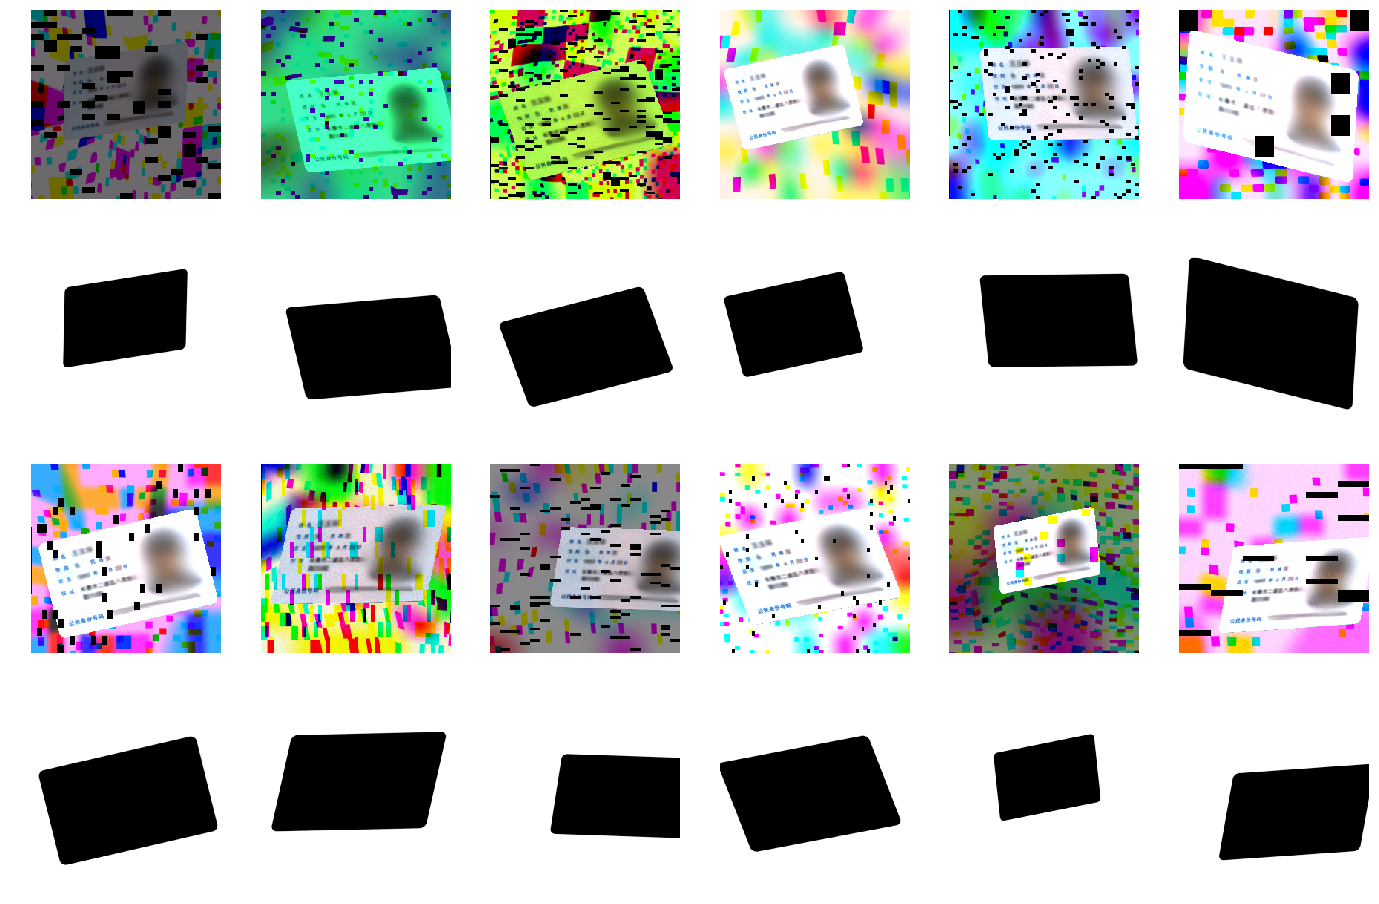

In [20]:
cols_count = 6
fig, axes = plt.subplots(4, cols_count, figsize=(24, 16)) # смотрим на первые 10 с масками
for k in range(cols_count):
    axes[0, k].set_axis_off()
    axes[0, k].imshow(train_x[k])
    axes[1, k].set_axis_off()
    axes[1, k].imshow(train_y[k].squeeze())
    axes[2, k].set_axis_off()
    axes[2, k].imshow(train_x[k + cols_count])
    axes[3, k].set_axis_off()
    axes[3, k].imshow(train_y[k + cols_count].squeeze())


In [21]:
input_layer = Input((h_size, w_size, 3))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-3), metrics=[my_iou_metric])
model.save_weights('./keras.weights')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
while True:
    history = model.fit(train_x, train_y,
                        batch_size=32,
                        epochs=1,
                        verbose=1,
                        validation_split=0.1
                       )
    if history.history['my_iou_metric'][0] > 0.97:
        break

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 217s 24ms/step - loss: 0.4964 - my_iou_metric: 0.6036 - val_loss: 0.1976 - val_my_iou_metric: 0.8331
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 208s 23ms/step - loss: 0.1659 - my_iou_metric: 0.8754 - val_loss: 0.1401 - val_my_iou_metric: 0.8956
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 207s 23ms/step - loss: 0.1135 - my_iou_metric: 0.9262 - val_loss: 0.1064 - val_my_iou_metric: 0.9288
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 207s 23ms/step - loss: 0.0889 - my_iou_metric: 0.9480 - val_loss: 0.0748 - val_my_iou_metric: 0.9558
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 207s 23ms/step - loss: 0.0784 - m

In [0]:
# genarate test image
test_num = 1
test_x = np.zeros((test_num, h_size, w_size, 3), dtype='float32')
for k in range(test_num): # генерация всех img train
    img, msk = next_pair()
    test_x[k] = img
test_x = test_x

In [0]:
# predict mask
test_y = model.predict(test_x)

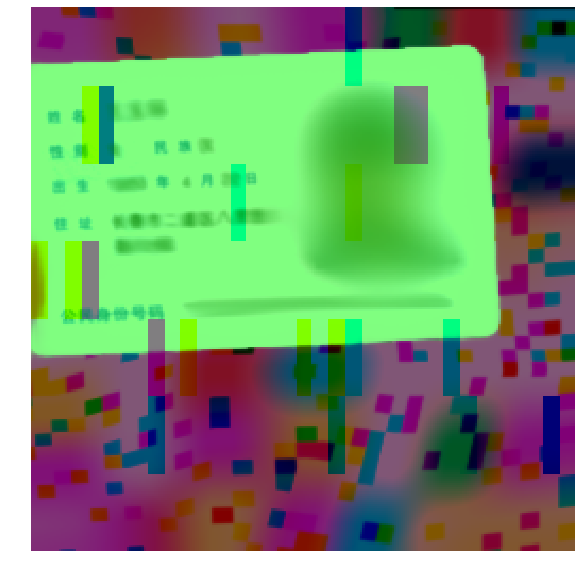

In [25]:
# show predict mask above test image
extent = 0, w_size, 0, h_size
fig = plt.figure(frameon=False, figsize=(10, 10))
im1 = plt.imshow(test_x[0], extent=extent)
plt.axis('off')
test_mask = test_y[0]
test_mask = test_mask.reshape(256, 256)
zero_layer = np.zeros((256, 256), dtype='float32')
stacked_img = np.stack((zero_layer, test_mask, zero_layer), axis=-1)
im2 = plt.imshow(stacked_img, alpha=0.5, extent=extent)

In [0]:
def genarate_test_image():
    test_x = np.zeros((h_size, w_size, 3), dtype='float32')
    img, msk = next_pair()
    test_x = img
    return test_x

In [0]:
def show_predict_mask_above_image(test_image):
    test_x = np.zeros((1, h_size, w_size, 3), dtype='float32')
    test_x[0] = test_image
    
    # predict mask
    test_y = model.predict(test_x)
    
    # show predict mask above test image
    extent = 0, w_size, 0, h_size
    fig = plt.figure(frameon=False, figsize=(10, 10))
    im1 = plt.imshow(test_image, extent=extent)
    plt.axis('off')
    test_mask = test_y[0]
    test_mask = test_mask.reshape(256, 256)
    zero_layer = np.zeros((256, 256), dtype='float32')
    stacked_img = np.stack((zero_layer, test_mask, zero_layer), axis=-1)
    im2 = plt.imshow(stacked_img, alpha=0.5, extent=extent)

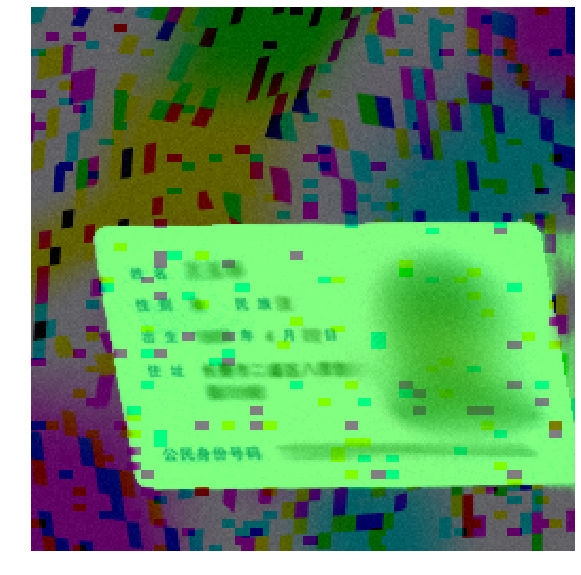

In [28]:
test_img = genarate_test_image()
show_predict_mask_above_image(test_img)

# TESTING ON NEW IMAGES

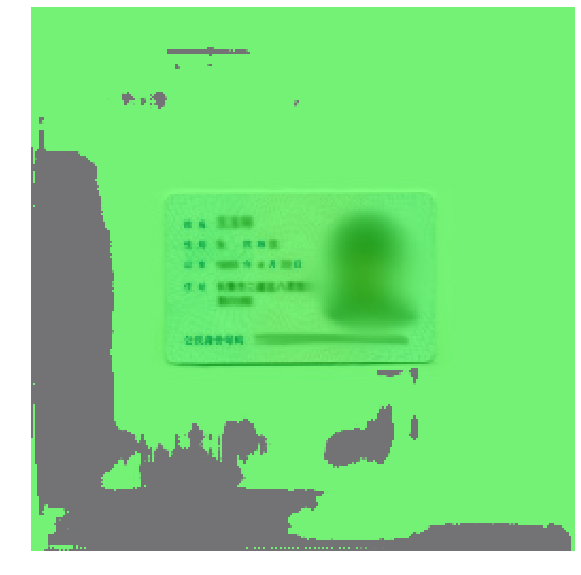

In [29]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_blur2_256.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)

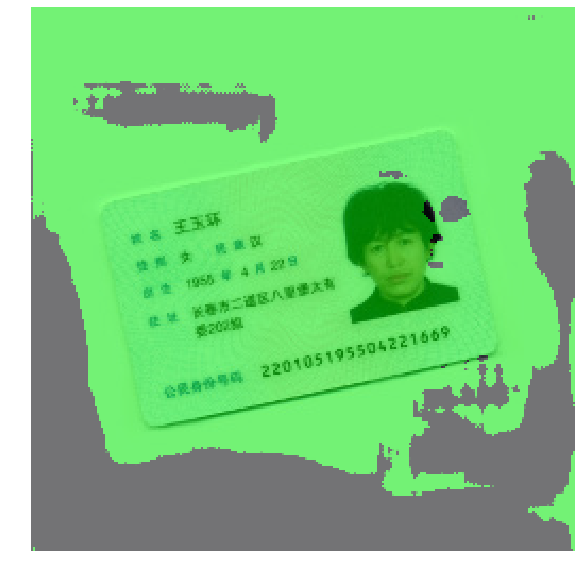

In [30]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_rot_256.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)

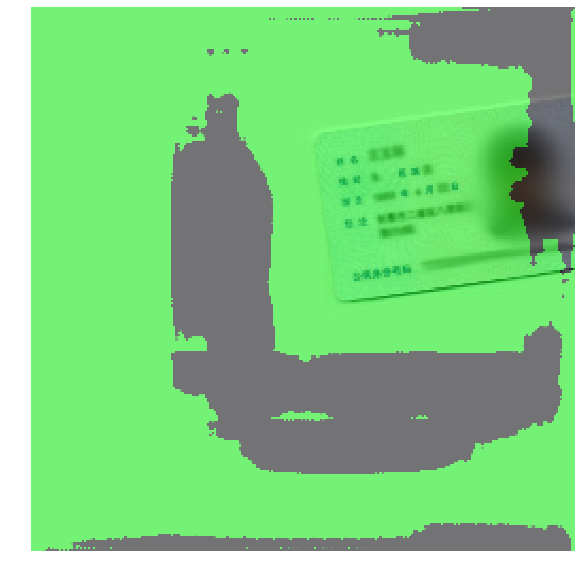

In [31]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_blur_rot_256.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)

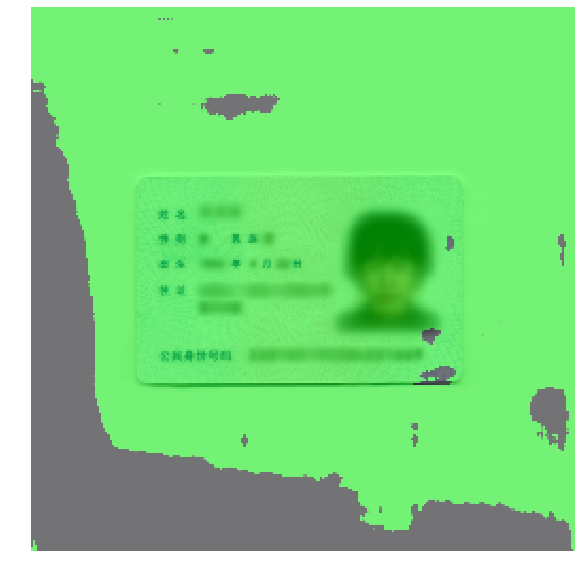

In [32]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_blur_256.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)

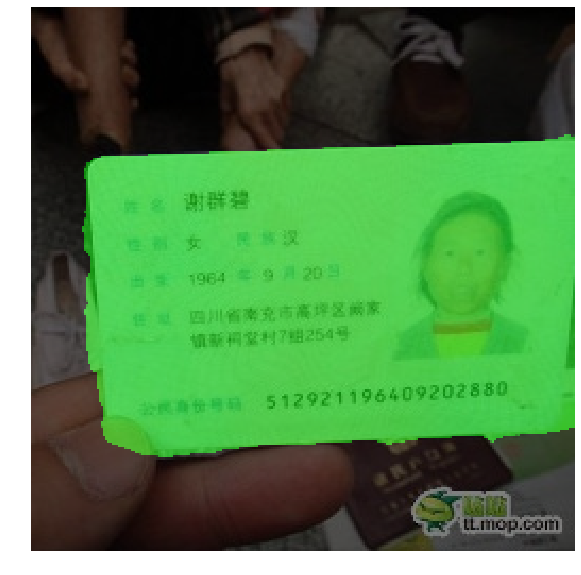

In [33]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/test/test_001.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)

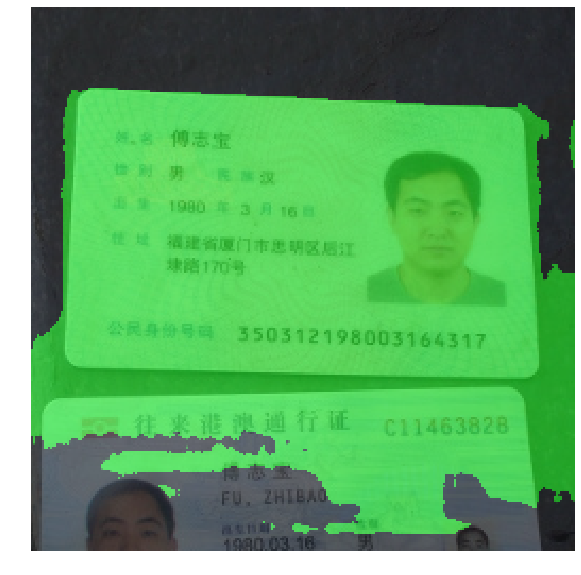

In [34]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/test/test_002.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)

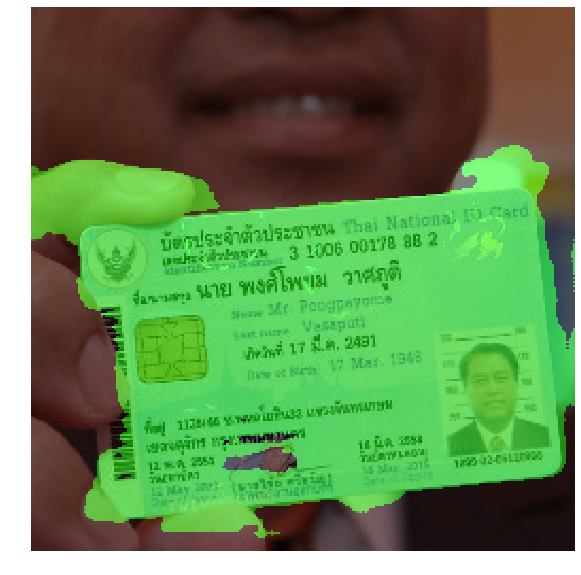

In [35]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/test/test_003.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)